In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

DATASET = 'rigid-dataset'

def get_residue_distance_path(dataset):
    return f'../../../data/features/residue-distances/{dataset}'
def get_fluctuation_path(dataset):
    return f'../../../data/features/fluctuation/{dataset}/fluctuation'
def get_indices_path(dataset):
    return f'../../../data/features/fluctuation/{dataset}/indices'

### Histogram of avg. distances

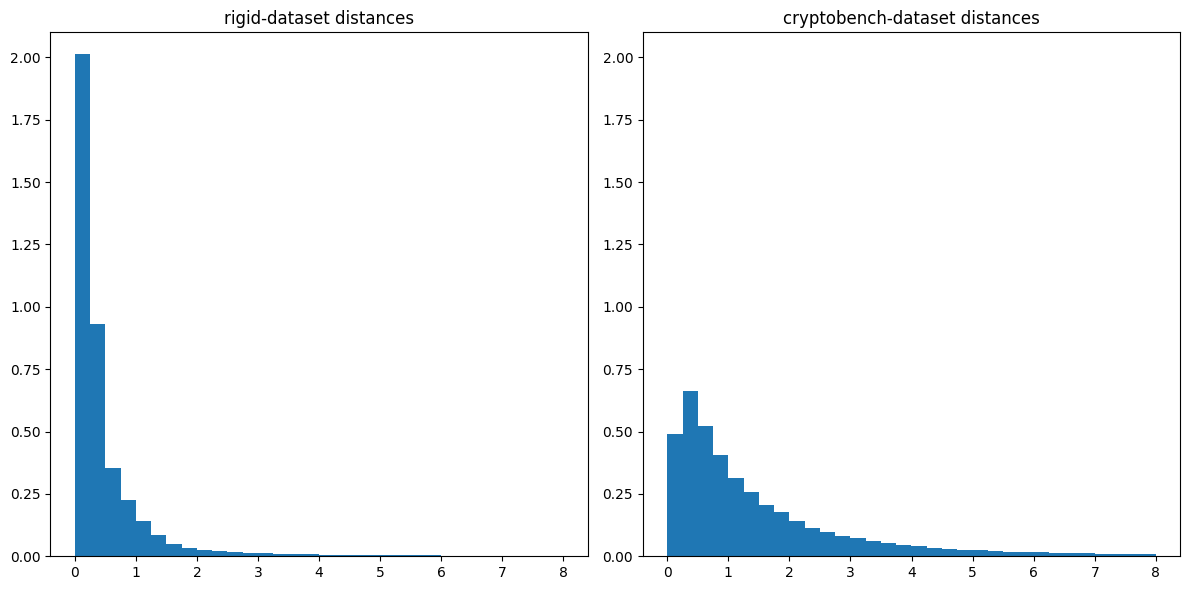

In [84]:
def plot_residue_distances(dataset):
    residue_distances_path= get_residue_distance_path(dataset)

    def get_residue_distances(path):
        residue_distances = {}
        for file in os.listdir(path):
            residue_distances[file.split('.')[0]] = np.load(f"{path}/{file}")
        return residue_distances

    distances = get_residue_distances(residue_distances_path)

    concatenated_distances = np.array([])
    for key, value in distances.items():
        concatenated_distances = np.concatenate((concatenated_distances, value))

    trimmed_distances = concatenated_distances[(concatenated_distances < 8) & (concatenated_distances > 0)]
    return trimmed_distances

datasets = ['rigid-dataset', 'cryptobench-dataset']
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, dataset in enumerate(datasets):
    trimmed_distances = plot_residue_distances(dataset)
    axs[i].hist(trimmed_distances, bins=32, density=True)
    axs[i].set_title(f'{dataset} distances')
    axs[i].set_ylim(0, 2.1)

plt.tight_layout()
plt.show()

### Create 4 bins
Let's create four intervals: [0, 0.5], [0.5, 1.5], [1.5, 2.5], [2.5, inf]. For each interval, show how fluctuation is behaving.

In [96]:
import numpy as np

def bin_fluctuations_by_distance(dataset, bins, labels):
    binned_fluctuation = {label: [] for label in labels}
    for file in os.listdir(get_residue_distance_path(dataset)):
        fluctuations = np.load(f"{get_fluctuation_path(dataset)}/{file}")
        distances = np.load(f"{get_residue_distance_path(dataset)}/{file}")

        # fluctuations[0] means the first mode, fluctuation[0][1] means the first mode for the second residue, etc.

        # let's transpose it:
        fluctuations = np.transpose(fluctuations)
        # now fluctuations[0] means the fluctuations of the first residue, fluctuations[0][1] means the fluctuations of the second mode for the first residue, etc.

        # loop over the residues
        for residue_idx, residue_fluctuation in enumerate(fluctuations):
            # check which bin the distance of the residue falls into
            for i, bin in enumerate(bins):
                if bins [i] < distances[residue_idx] <= bins[i+1]:
                    binned_fluctuation[labels[i]].append(residue_fluctuation)

    # now we have the binned fluctuations dictionary
    # each key is a distance bin
    # each value is a list of residues
    # now we want to have a similar dictionary, but the values is a list of modes, so we need to transpose the entries

    binned_fluctuation_transposed = {label: [] for label in labels}

    # for each distance bin
    for label, residues in binned_fluctuation.items():
        # for each residue
        for residue in residues:
            for mode_index, mode_value in enumerate(residue):
                # if the mode is not yet in the bin, add it
                if len(binned_fluctuation_transposed[label]) <= mode_index:
                    binned_fluctuation_transposed[label].append([])
                # add the residue to the correct mode
                binned_fluctuation_transposed[label][mode_index].append(mode_value)
    del binned_fluctuation

    for label, fluctuations in binned_fluctuation_transposed.items():
        for i, fluctuation in enumerate(fluctuations):
            binned_fluctuation_transposed[label][i] = np.array(fluctuation)
    return binned_fluctuation_transposed


def print_barcharts(binned_fluctuation_transposed, title='', lim=None):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    for (label, data), figure_index in zip(binned_fluctuation_transposed.items(), [221,222,223,224]):

        plt.subplot(figure_index)
        # Compute median values for each position
        binding_medians = [np.median(dato) for dato in data]
        ylim = np.max(binding_medians)
        plt.bar(range(0, len(binding_medians)), binding_medians, width=1.0, alpha=0.7, label=f'{label} distance interval')
        plt.title(f'Median value for each mode in distance interval {label}')
        plt.xlabel('Mode')
        if lim:
            plt.ylim(0, lim)
        else:
            plt.ylim(0, ylim)
        plt.ylabel('Median Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

def print_combined_barcharts(binned_fluctuation_cryptobench, binned_fluctuation_transposed_rigid, title='', lim=None, legends=None, compute_median=False):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    for ((label1, data1), (label2, data2)), figure_index in zip(zip(binned_fluctuation_cryptobench.items(), binned_fluctuation_transposed_rigid.items()), [221,222,223,224]):

        plt.subplot(figure_index)
        if compute_median:
            data1 = [np.median(dato) for dato in data1]
            data2 = [np.median(dato) for dato in data2]
        
        # Compute median values for each position
        ylim = max(np.max(data1), np.max(data2))
        if legends:
            legend1 = f'{label1} {legends[0]}'
            legend2 = f'{label1} {legends[1]}'
        else:
            legend1 = f'{label1} CryptoBench distance interval'
            legend2 = f'{label1} Rigid distance interval'
            
        plt.bar(range(0, len(data1)), data1, width=1.0, alpha=0.7, label=legend1)
        plt.bar(range(0, len(data2)), data2, width=1.0, alpha=0.5, label=legend2)
        plt.title(f'Median value for each mode in distance interval {label1}')
        plt.xlabel('Mode')
        if lim:
            plt.ylim(0, lim)
        else:
            plt.ylim(0, ylim)
        plt.ylabel('Median Value')
        plt.legend()

    plt.tight_layout()
    plt.show()


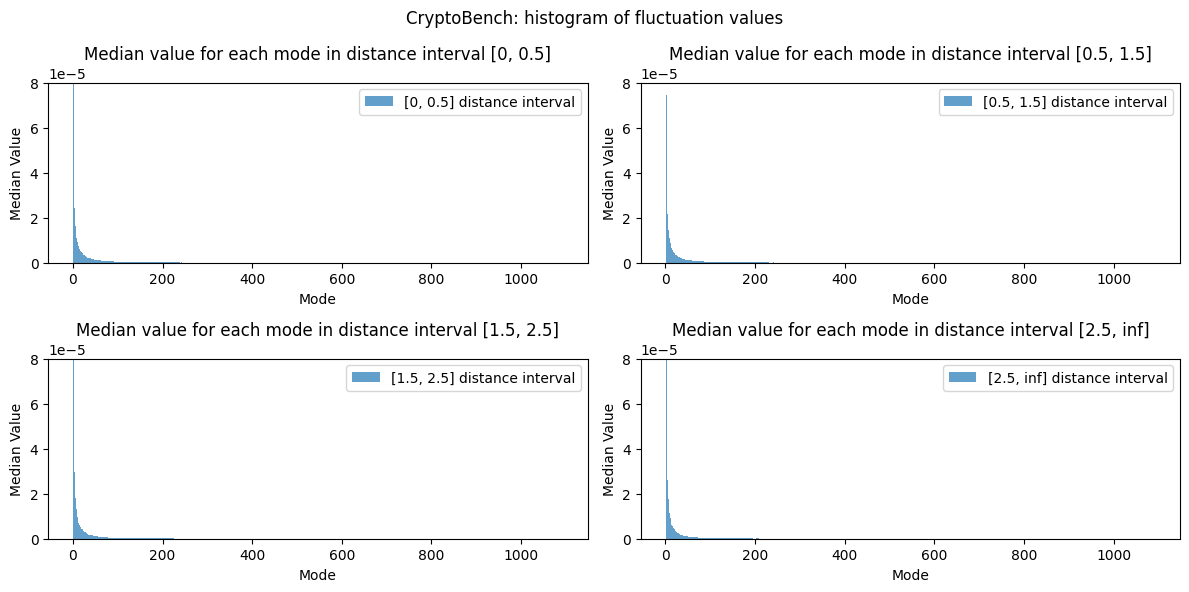

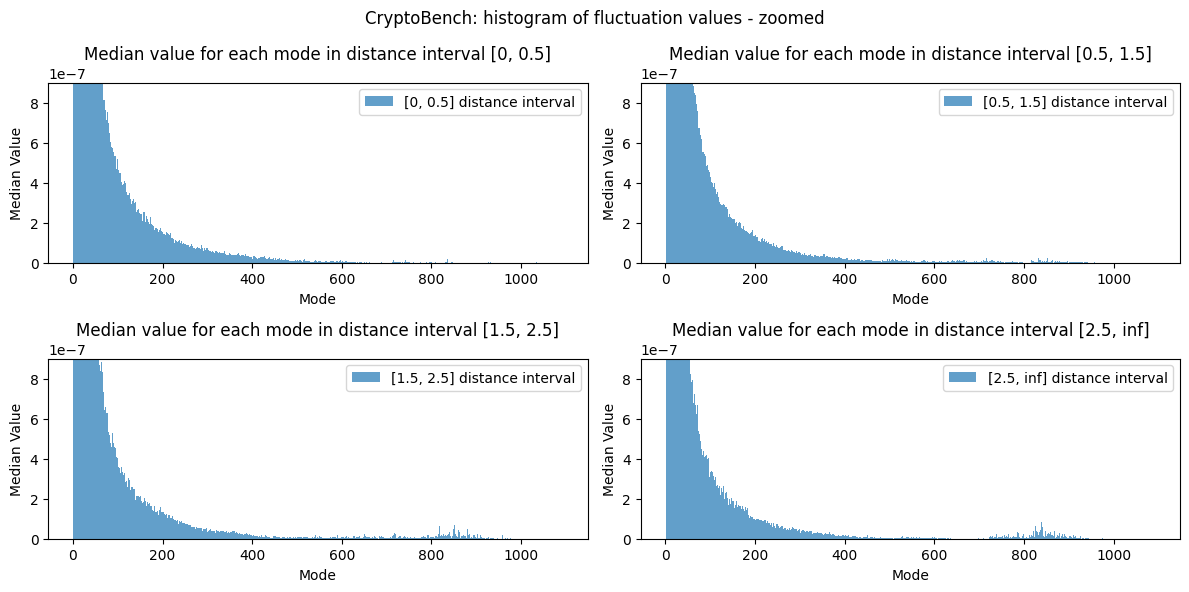

In [6]:
bins = [0, 0.5, 1.5, 2.5, np.inf]
labels = ['[0, 0.5]', '[0.5, 1.5]', '[1.5, 2.5]', '[2.5, inf]']

dataset = 'cryptobench-dataset'

binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels)

print_barcharts(binned_fluctuation_by_distance, title='CryptoBench: histogram of fluctuation values', lim=8e-05)
print_barcharts(binned_fluctuation_by_distance, title='CryptoBench: histogram of fluctuation values - zoomed', lim=9e-07)

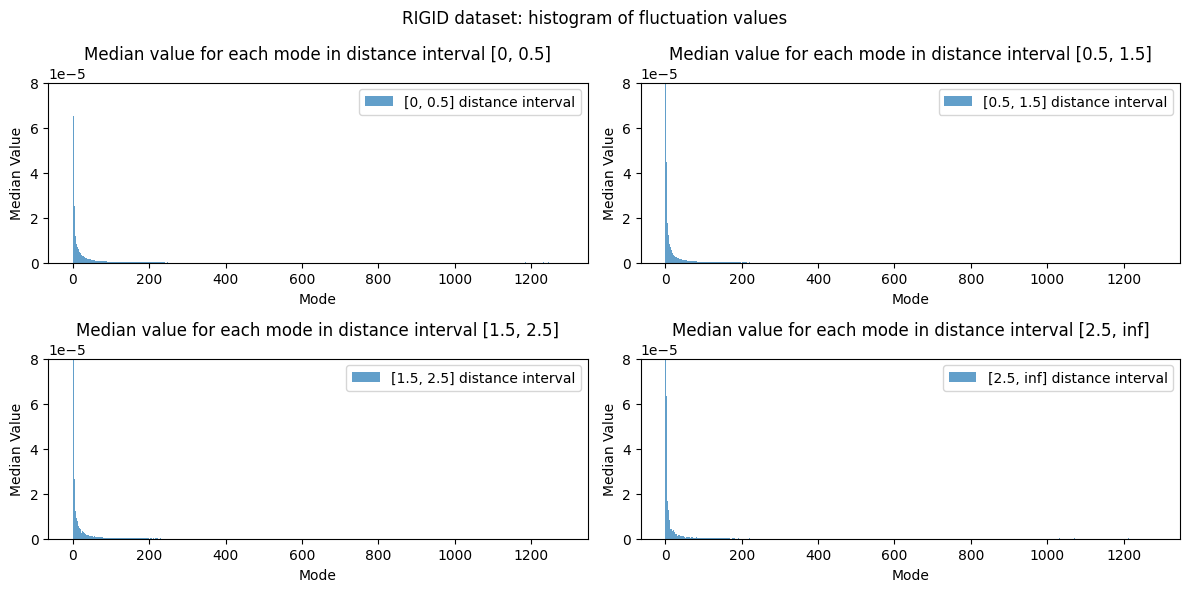

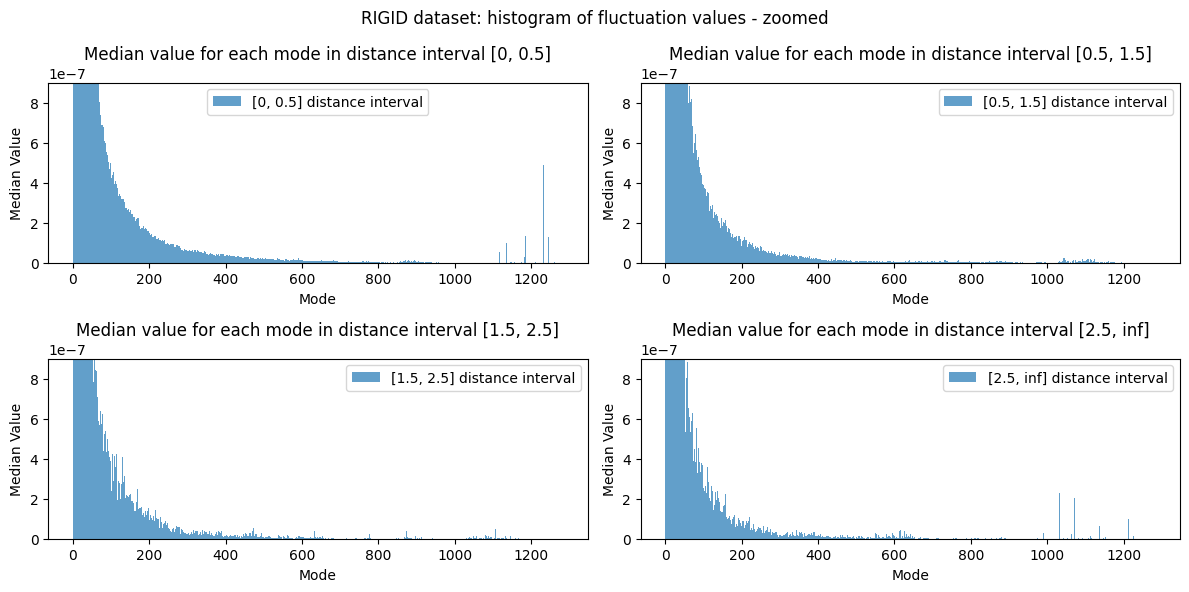

In [85]:
bins = [0, 0.5, 1.5, 2.5, np.inf]
labels = ['[0, 0.5]', '[0.5, 1.5]', '[1.5, 2.5]', '[2.5, inf]']

dataset = 'rigid-dataset'

binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels)

print_barcharts(binned_fluctuation_by_distance, title='RIGID dataset: histogram of fluctuation values', lim=8e-05)
print_barcharts(binned_fluctuation_by_distance, title='RIGID dataset: histogram of fluctuation values - zoomed', lim=9e-07)

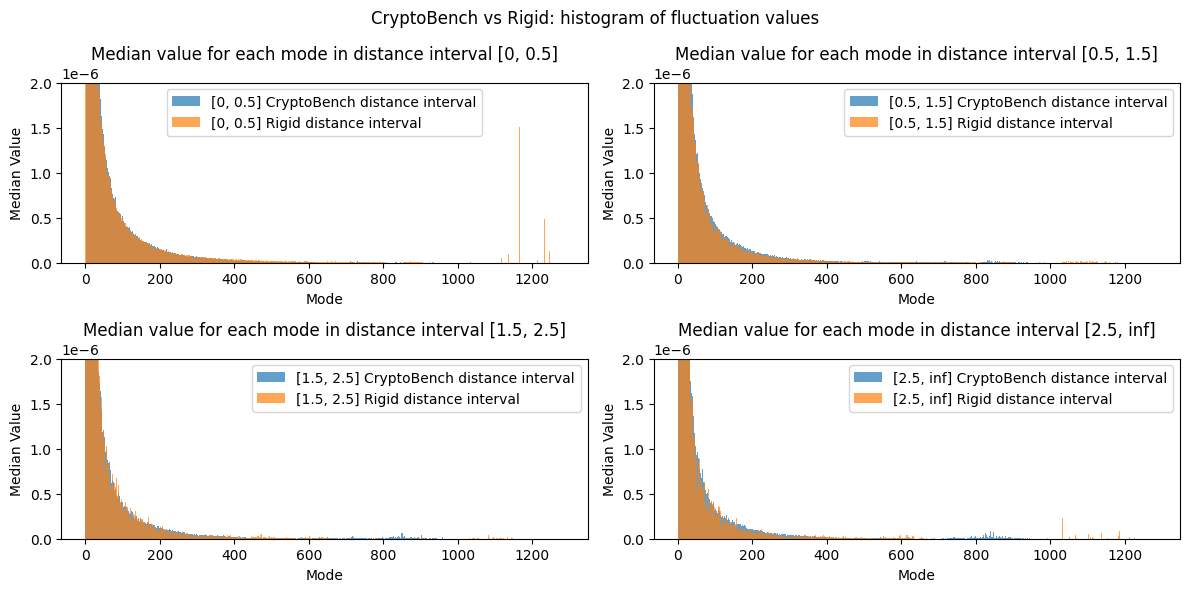

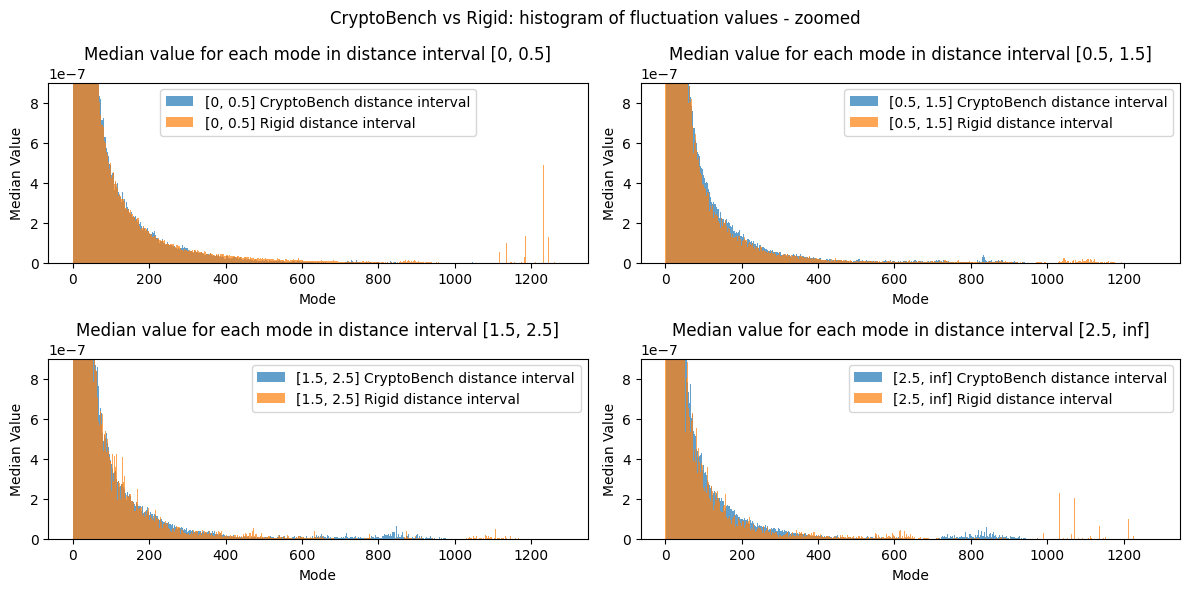

In [8]:
bins = [0, 0.5, 1.5, 2.5, np.inf]
labels = ['[0, 0.5]', '[0.5, 1.5]', '[1.5, 2.5]', '[2.5, inf]']

def load_dataset_and_pick_median(dataset):
    binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels)
    for label in binned_fluctuation_by_distance.keys():
        binned_fluctuation_by_distance[label] = [np.median(dato) for dato in binned_fluctuation_by_distance[label]]
    return binned_fluctuation_by_distance

binned_fluctuation_by_distance_cryptobench = load_dataset_and_pick_median('cryptobench-dataset')
binned_fluctuation_by_distance_rigid = load_dataset_and_pick_median('rigid-dataset')

print_combined_barcharts(binned_fluctuation_by_distance_cryptobench, binned_fluctuation_by_distance_rigid, title='CryptoBench vs Rigid: histogram of fluctuation values', lim=2e-06)
print_combined_barcharts(binned_fluctuation_by_distance_cryptobench, binned_fluctuation_by_distance_rigid, title='CryptoBench vs Rigid: histogram of fluctuation values - zoomed', lim=9e-07)

Mmmm the median values between cryptobench and rigid seem very similar..

Let's look into the first 200 modes:

/tmp/ipykernel_4181/687924379.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


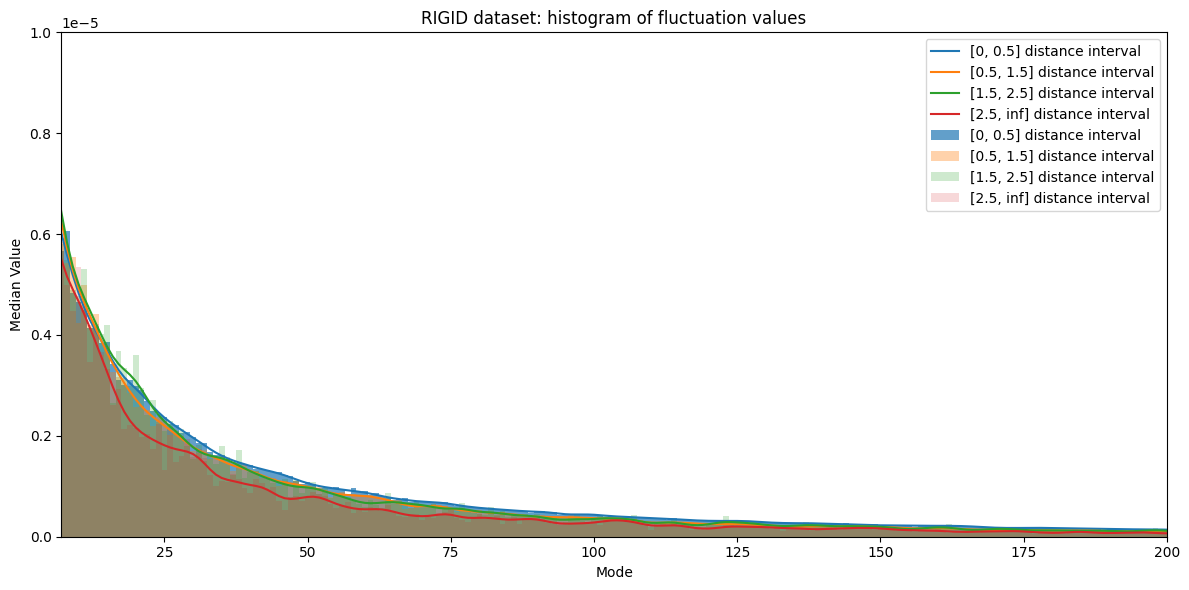

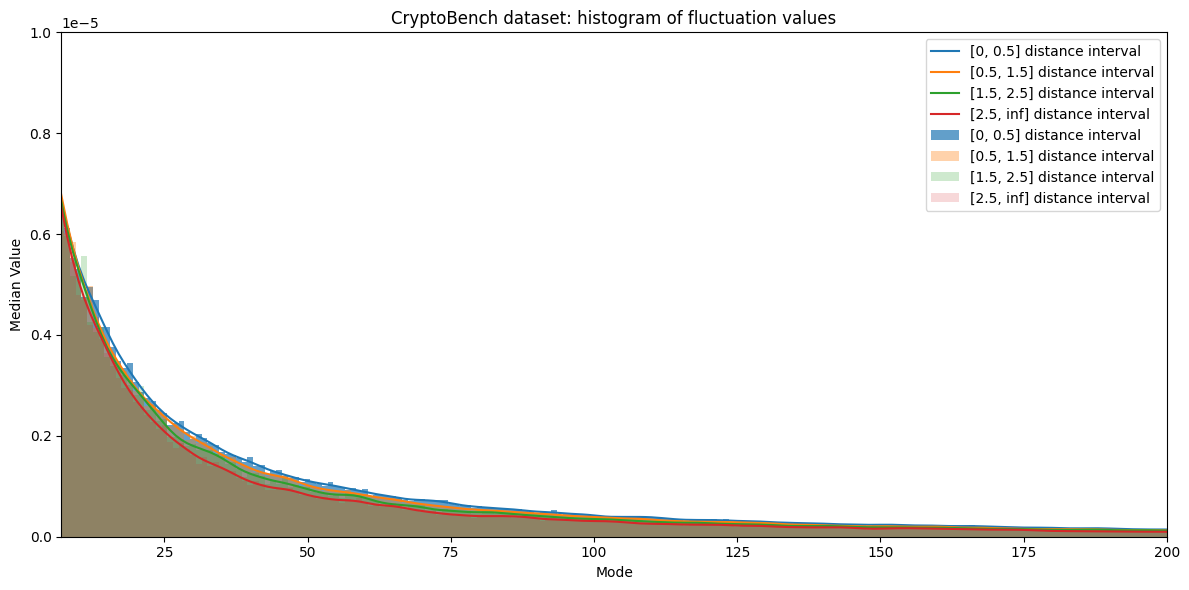

In [86]:
from scipy.ndimage.filters import gaussian_filter1d

def combine_barcharts_over_distances(binned_fluctuation, title='', ylim=None, xlim=None):
    plt.figure(figsize=(12, 6))
    for i, (label1, data1) in enumerate(binned_fluctuation.items()):
        if xlim:
            data1 = data1[xlim[0]:]
        # Compute median values for each position
        plt.bar(range(0, len(data1)), data1, width=1.0, alpha=0.7 * (1 / (i + 1)), label=f'{label1} distance interval')
        ysmoothed = gaussian_filter1d(data1, sigma=2)
        plt.plot(range(0, len(data1)), ysmoothed, label=f'{label1} distance interval')
    plt.xlabel('Mode')
    if ylim:
        plt.ylim(0, ylim)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    plt.ylabel('Median Value')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()
combine_barcharts_over_distances(binned_fluctuation_by_distance_rigid, title='RIGID dataset: histogram of fluctuation values', ylim=1e-05, xlim=(7,200))
combine_barcharts_over_distances(binned_fluctuation_by_distance_cryptobench, title='CryptoBench dataset: histogram of fluctuation values', ylim=1e-05, xlim=(7,200))

Analyze the binding sites:

In [89]:
def get_indices_path(dataset):
    return f'../../../data/features/fluctuation/{dataset}/indices'

def bin_fluctuations_by_distance_and_binding(dataset, bins, labels):
    binned_fluctuation_binding = {label: [] for label in labels}
    binned_fluctuation_nonbinding = {label: [] for label in labels}
    for file in os.listdir(get_residue_distance_path(dataset)):
        fluctuations = np.load(f"{get_fluctuation_path(dataset)}/{file}")
        distances = np.load(f"{get_residue_distance_path(dataset)}/{file}")
        indices = np.load(f"{get_indices_path('rigid-dataset')}/{file}")

        # fluctuations[0] means the first mode, fluctuation[0][1] means the first mode for the second residue, etc.

        # let's transpose it:
        fluctuations = np.transpose(fluctuations)
        # now fluctuations[0] means the fluctuations of the first residue, fluctuations[0][1] means the fluctuations of the second mode for the first residue, etc.

        # loop over the residues
        for residue_idx, residue_fluctuation in enumerate(fluctuations):
            # check which bin the distance of the residue falls into
            for i, bin in enumerate(bins):
                if bins [i] < distances[residue_idx] <= bins[i+1]:
                    if residue_idx in indices:
                        binned_fluctuation_binding[labels[i]].append(residue_fluctuation)
                    else:
                        binned_fluctuation_nonbinding[labels[i]].append(residue_fluctuation)

    # now we have the binned fluctuations dictionary
    # each key is a distance bin
    # each value is a list of residues
    # now we want to have a similar dictionary, but the values is a list of modes, so we need to transpose the entries

    binned_fluctuation_binding_transposed = {label: [] for label in labels}
    binned_fluctuation_nonbinding_transposed = {label: [] for label in labels}

    for binned_fluctuation, binned_fluctuation_transposed in zip([binned_fluctuation_binding, binned_fluctuation_nonbinding], [binned_fluctuation_binding_transposed, binned_fluctuation_nonbinding_transposed]):
        # for each distance bin
        for label, residues in binned_fluctuation.items():
            # for each residue
            for residue in residues:
                for mode_index, mode_value in enumerate(residue):
                    # if the mode is not yet in the bin, add it
                    if len(binned_fluctuation_transposed[label]) <= mode_index:
                        binned_fluctuation_transposed[label].append([])
                    # add the residue to the correct mode
                    binned_fluctuation_transposed[label][mode_index].append(mode_value)
        del binned_fluctuation

    for binned_fluctuation_transposed in [binned_fluctuation_binding_transposed, binned_fluctuation_nonbinding_transposed]:
        for label, fluctuations in binned_fluctuation_transposed.items():
            for i, fluctuation in enumerate(fluctuations):
                binned_fluctuation_transposed[label][i] = np.array(fluctuation)
    return binned_fluctuation_binding_transposed, binned_fluctuation_nonbinding_transposed

In [91]:
binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance = bin_fluctuations_by_distance_and_binding('rigid-dataset', bins, labels)

In [95]:
binding_binned_fluctuation_by_distance['[0, 0.5]'][0].shape

(3314,)

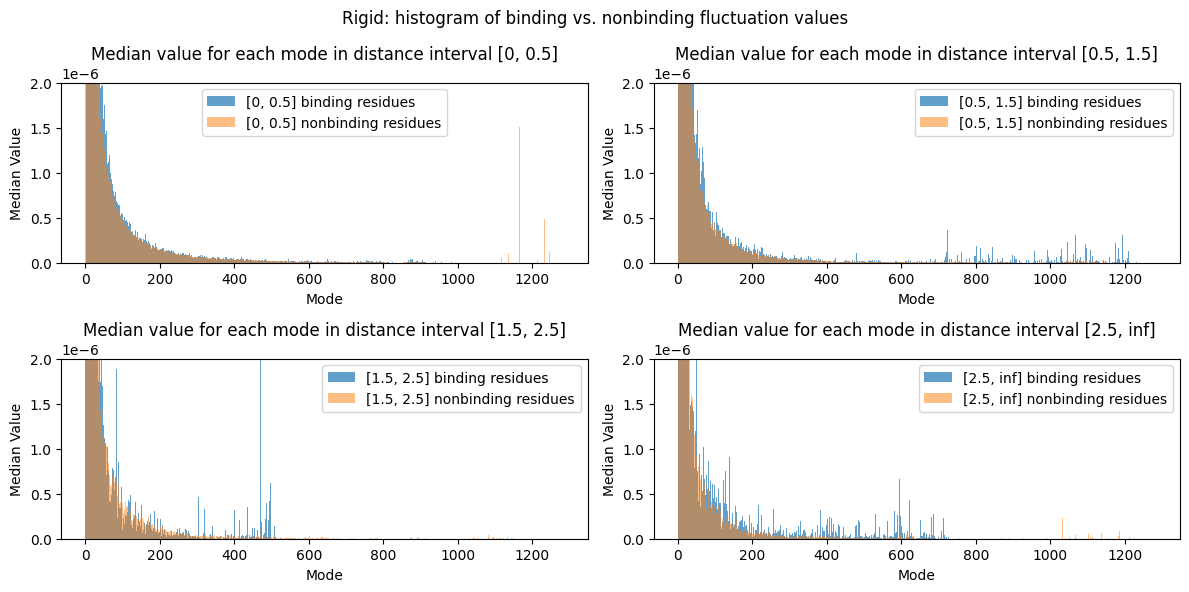

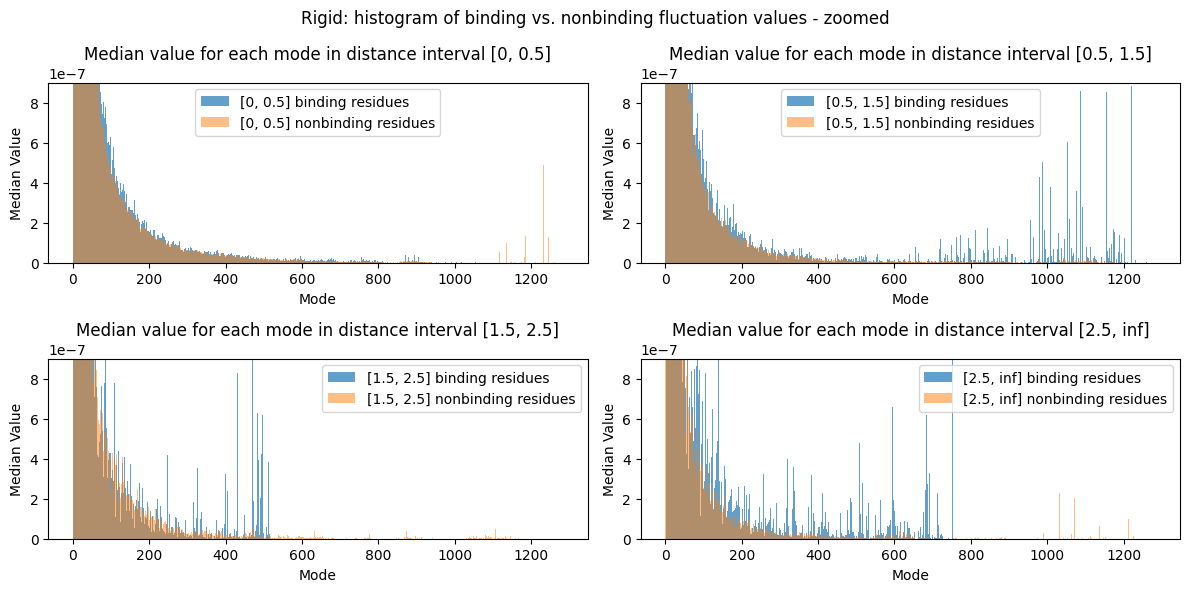

In [98]:
print_combined_barcharts(binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance, compute_median=True, legends=['binding residues', 'nonbinding residues'],title='Rigid: histogram of binding vs. nonbinding fluctuation values', lim=2e-06)
print_combined_barcharts(binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance, compute_median=True, legends=['binding residues', 'nonbinding residues'],title='Rigid: histogram of binding vs. nonbinding fluctuation values - zoomed', lim=9e-07)